# Part II: Calibration

## Introduction

In [1]:
# Uncomment to install packages
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade --quiet

%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import scipy

from time import time, sleep
from datetime import timedelta
import json

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, \
  mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
 
# Colors & Style
sns.set_style('whitegrid')
colormap = sns.color_palette("Blues", as_cmap=True)

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

random_seed = 42

print('Pandas', pd.__version__)
print('Seaborn', sns.__version__)
print('Scikit-learn', sklearn.__version__)

Pandas 1.2.4
Seaborn 0.11.1
Scikit-learn 0.24.2


In [3]:
df = pd.read_csv('data.csv', sep=';')

In [4]:
df.head()

,date,RefSt,Sensor_O3,Temp,RelHum
0,21/06/2017 7:00,15.0,36.3637,21.77,53.97
1,21/06/2017 7:30,15.0,34.8593,25.50,42.43
2,21/06/2017 8:00,19.0,37.3510,27.97,34.93
3,21/06/2017 8:30,26.0,43.6993,29.41,32.07
4,21/06/2017 9:00,34.0,53.9600,30.20,30.83


The units of the columns are the following:

- Temperature: °$C$
- Humidity(Relative): $\%$
- Ozone: $K\Omega$ 
- Real Ozone(Ozone): $\mu gr/m^3$

In [5]:
print(f'Columns: {df.shape[1]}\nRows: {df.shape[0]}')
print('Columns types:')
print(df.dtypes)

Columns: 5
Rows: 1000
Columns types:
date          object
RefSt        float64
Sensor_O3    float64
Temp         float64
RelHum       float64
dtype: object


Fix date type and sort by date:

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df['date'][:5]

0   2017-01-07 00:00:00
1   2017-01-07 00:30:00
2   2017-01-07 01:00:00
3   2017-01-07 01:30:00
4   2017-01-07 02:00:00
Name: date, dtype: datetime64[ns]

Fix columns' name and order:

In [7]:
new_columns = {
    'date': 'date',
    'RefSt': 'real_ozone',
    'Sensor_O3': 'ozone',
    'Temp': 'temperature',
    'RelHum': 'humidity'
}
df.rename(columns=new_columns, inplace=True)
new_order = ['date', 'temperature', 'humidity', 'ozone', 'real_ozone']
df = df.reindex(columns=new_order)
df.columns

Index(['date', 'temperature', 'humidity', 'ozone', 'real_ozone'], dtype='object')

In [8]:
df.describe().loc[['mean','std']]

,temperature,humidity,ozone,real_ozone
mean,24.966410,42.018640,234.839993,64.477000
std,6.443502,14.877965,172.064966,41.950129


Drop *date*: we will consider that the samples are independent to simplify the analysis.

In [9]:
df = df.drop(['date'], axis=1)

### Missing values

We need to deal with missing values.

In [10]:
def displayMissingValues():
    plt.title('Missing values',fontsize=12, y=-0.2)
    ax = sns.heatmap(
        pd.DataFrame(df.isna().sum()),
        annot=True, 
        fmt='d', 
        vmin=0, 
        vmax=df.shape[0], 
        cmap=colormap,
        yticklabels=['temp.','humidity','ozone','true ozone']
    )

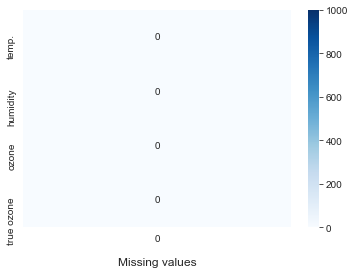

In [11]:
displayMissingValues()

Lucky, the dataset has already been preprocessed in terms of missing values.

## Data Visualization


In [12]:
colorDict = {
    'temperature': 'lightcoral',
    'humidity': 'cornflowerblue',
    'ozone': 'limegreen',
    'real_ozone': 'gold',
}

palette = sns.color_palette(list(colorDict.values()))

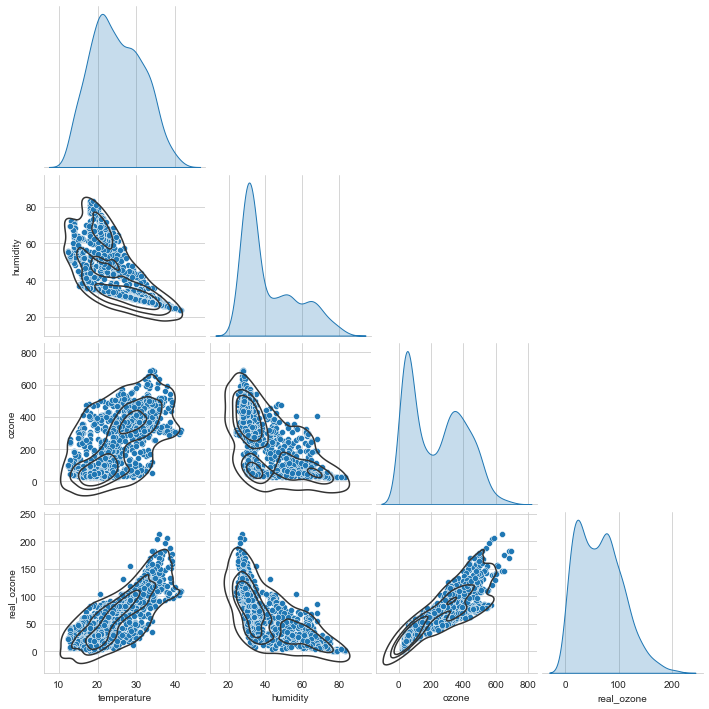

In [13]:
g = sns.pairplot(df, diag_kind='kde', palette=palette, corner=True)
_ = g.map_lower(sns.kdeplot, levels=4, color=".2")

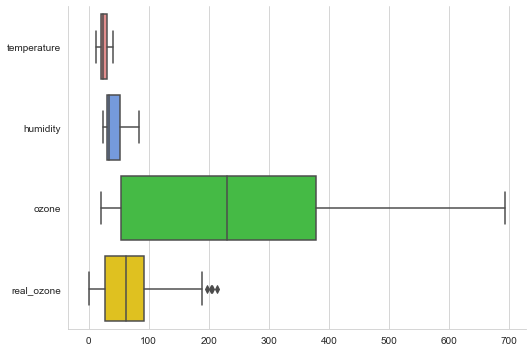

In [14]:
_ = sns.catplot(data=df, 
            kind='box', 
            orient='h', 
            height=5, 
            aspect=1.5, 
            palette=palette)

Data is clearly not normalized so we will scale it during the preprocessing.

In [15]:
font = {'size': 14, 'weight': 'bold'}

def plot_hist_box(df, col, color):
    fig, axs= plt.subplots(1,2, gridspec_kw = {'width_ratios': [4, 1]}, figsize = (9,4), sharey=False)
    axs[0].set_xlabel(axs[0].get_xlabel(),fontdict=font)
    axs[0].set_title('Histogram with KDE')
    axs[1].set_title('Boxplot')
    hist = sns.histplot(data=df, x=col, kde=True, element='step', fill=True, ax=axs[0], color=color)
    _ = sns.boxplot(data=df, y=col, ax=axs[1], color=color)

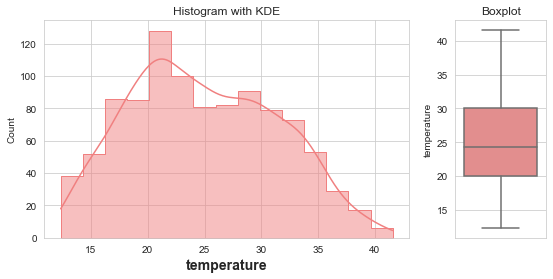

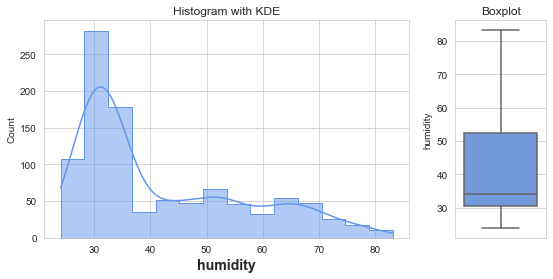

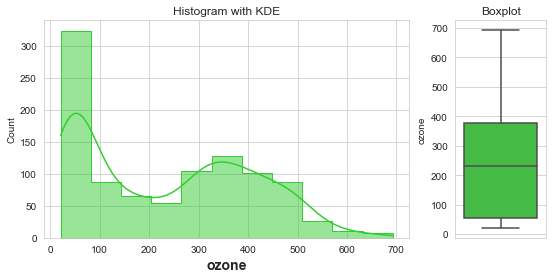

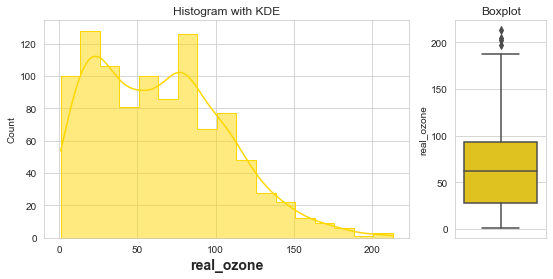

In [16]:
for col in df.columns:
    color = colorDict[col]
    plot_hist_box(df, col, color=color)

All three 'humidity', 'ozone', and 'real ozone' are *skewed* and contains some *outliers*.

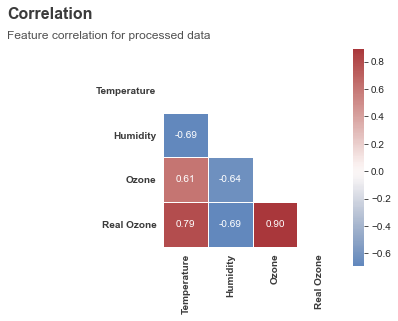

In [17]:
cmap = sns.color_palette("vlag", as_cmap=True)

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (4,4))
sns.heatmap(corr, ax=ax, fmt='.2f', cmap=cmap, annot=True,
            center=0, mask=mask, linewidths=.5, square=True)
ax.text(-3.5,-1.1, 'Correlation',{'size': 16, 'weight':'bold'}, alpha = 0.9)
ax.text(-3.5,-0.65, 'Feature correlation for processed data',{'size': 12, 'weight':'normal'}, alpha = 0.8)
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Temperature', 'Humidity', 'Ozone','Real Ozone']
yticks = ['Temperature', 'Humidity', 'Ozone','Real Ozone']
ax.set_xticklabels(xticks, {'size':10, 'weight':'bold'},rotation = 90, alpha = 0.9)
ax.set_yticklabels(yticks, {'size':10, 'weight':'bold'}, rotation = 0, alpha = 0.9)

fig.show()

### Outliers

Real ozone seems to have some *outliers* (see Real Ozone boxplot).

(789, 4)


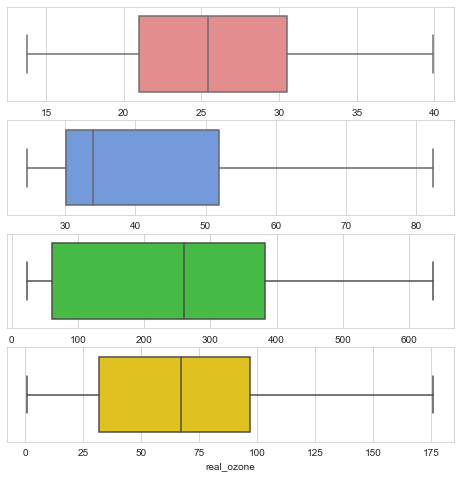

In [18]:
df_aux = df.copy()

for col in df.columns:
    lof = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
    result = lof.fit_predict(df_aux[col].values.reshape(-1, 1))
    df_aux = df_aux[result == 1]
print(df_aux.shape)

fig, axs = plt.subplots(4, figsize=(8,8), sharey=False)
for i, col in enumerate(df_aux.columns):
    _ = sns.boxplot(data=df_aux, x=col, ax=axs[i], color=colorDict[col])

We decided **not to filter out** the possible outliers since *Local Outlier Factor* is removing ~200 samples which is a 20% of the total.

### Normalization

The features 'humidity', 'ozone', and 'real ozone' are *skewed* as we saw in the histograms from the previous section. 

We can avoid this that applying a *logarithm* to this column, as all values are positive.

In [19]:
def plot_hist_log(df, col, color):
    fig, axs= plt.subplots(1,2, gridspec_kw = {'width_ratios': [2, 2]}, figsize = (9,4), sharey=False)
    axs[0].set_title('')
    axs[1].set_title('$\log_{10}$')
    hist = sns.histplot(data=df, x=col, kde=True, element='step', fill=True, ax=axs[0], color=color)
    hist = sns.histplot(log_scale=True,data=df, x=col, kde=True, element='step', fill=True, ax=axs[1], color=color)

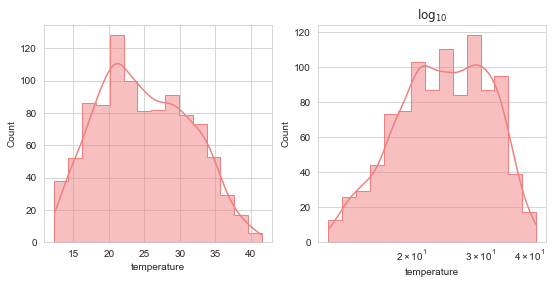

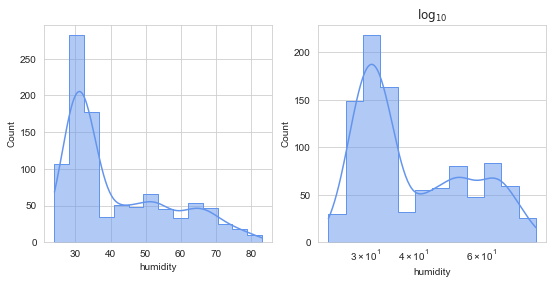

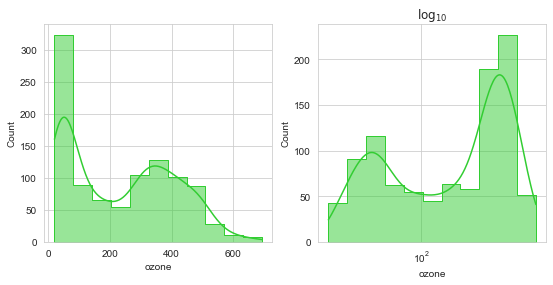

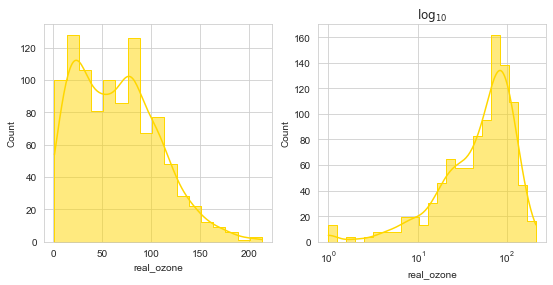

In [20]:
for col in df.columns:
    color = colorDict[col]
    plot_hist_log(df, col, color=color)

Changing the scale on 'temperature' and 'real ozone' seems to have worked but 'humidity' and 'ozone' still have this multivariate normal distribution shape.

### Factor analysis

Factor analysis in this dataset is not worth exploring since the number of variables is already really small.

## Modeling

Pick the best model and hyperparameters.

### Preprocessing and Resampling

We use a RobustScaler since the StandardScaler does not work well in the presence of outliers (see [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)).

In [21]:
def preprocessing(X, y):
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    return X, y

In [22]:
X = df.loc[:, df.columns != 'real_ozone']
y = df['real_ozone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_seed)

X_train, y_train = preprocessing(X_train, y_train)
X_val, y_val = preprocessing(X_val, y_val)
X_test, y_test = preprocessing(X_test, y_test)

print('Train: ', X_train.shape)
print('Validation: ', X_val.shape)
print('Test: ', X_test.shape)

Train:  (600, 3)
Validation:  (200, 3)
Test:  (200, 3)


### Metrics

We are going to use the following regression metrics:

$$
MAE(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^{n-1} |y_i - \hat{y_i}|
$$

$$
MSE(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^{n-1} (y_i - \hat{y_i})^2
$$

$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y_i})^2}
$$

In [23]:
metrics = ['MAE', 'MSE', '$R^2$']
results = pd.DataFrame(columns=metrics)

In [24]:
def plot_results():
    display(results.sort_values(by='MAE',ascending=True))

In [25]:
def compute_metrics(y_true,y_pred):
    """Returns an array with all the metrics."""
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    return [mae,
            mse,
            r2,
           ]

def evaluate(name, model, print_results=True):
    """Evaluates the model with the validation dataset."""
    try:
        model = model.best_estimator_
    except Exception as e:
        pass
    y_pred = model.predict(X_val)
    results.loc[name,:] = compute_metrics(y_val, y_pred)
    if print_results:
        plot_results()

### Model Selection

We are going to explore the following models:
- Linear Regression
- k-Nearest Neighbors Regression
- Random Forest Regression
- Kernel Regression
- Gaussian Process
- Support Vector Regression
- Neural Networks

First, we will evaluate the models with *default parameters*. Then, we are going to carefully tune the *hyperparameters* to get the best score out of them.

In [26]:
lr = LinearRegression(normalize=False)
ridge = Ridge(normalize=False, random_state=random_seed)
sgd = SGDRegressor(random_state=random_seed)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state=random_seed)
krr = KernelRidge()
gp = GaussianProcessRegressor(random_state=random_seed)
svr = SVR()
nn = MLPRegressor(random_state=random_seed)

models = {
    'LR(default)': lr,
    'Ridge(default)': ridge,
    'LR-SGD(default)': sgd,
    'KNN(default)': knn,
    'RF(default)': rf,
    'KRR(default)': krr,
    'GP(default)': gp,
    'SVR(default)': svr,
    'NN(default)': nn,
}

In [27]:
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate(name, model, print_results=False)
    
plot_results()

,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
RF(default),8.52765,109.374549,0.937331
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
SVR(default),11.970851,296.557886,0.830078
GP(default),13.635264,959.67947,0.450122
NN(default),18.961444,524.995914,0.699188
KRR(default),41.821578,2408.593873,-0.380077


The best model with default parameters is the Random Forest followed by K-Nearest Neighbors.

#### Hypertunning

In [28]:
def print_time(start, end):
    duration = timedelta(seconds=end-start)
    days, seconds = duration.days, duration.seconds
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    print(f'{minutes} minutes, {seconds} seconds')
    
def print_best_params(cvModel):
    stringified = json.dumps(cvModel.best_params_, sort_keys=False, indent=2)
    print(stringified)

In [29]:
def hypertune(estimator, param_grid, extra_scoring_cols, print_scores=True, cv=10):
    """Returns the model hypertunned."""
    scoring_cols = extra_scoring_cols + [
        'mean_test_mae', 
        'mean_test_mse', 
        'mean_test_r2'
    ]
    
    scoring_dict = {
        'mae': 'neg_mean_absolute_error',
        'mse': 'neg_mean_squared_error',
        'r2': 'r2',
    }

    start = time()
    
    cvModel = GridSearchCV(
        estimator=estimator,
        scoring=scoring_dict,
        param_grid=param_grid,
        refit='mae',
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )

    cvModel = cvModel.fit(X_train, y_train)
    
    print_time(start, time())
    
    scores = pd.DataFrame(cvModel.cv_results_) \
              .sort_values(by='mean_test_mae',ascending=False)[scoring_cols] \
              .head()
    
    if print_scores:
        print_best_params(cvModel)
        display(scores)
    
    return cvModel

#### Multiple Linear Regression

Before applying *linear regression* we should validate if our data follow the assumptions.

In [30]:
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             real_ozone   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     1634.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):          5.20e-287
Time:                        19:04:39   Log-Likelihood:                -2433.5
No. Observations:                 600   AIC:                             4875.
Df Residuals:                     596   BIC:                             4893.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.1791      0.747     85.890      0.000      62.712      65.647
x1            25.7493      1.284     20.052      0.000      23.227      28.271
x2            -0.0485      1.271     -0.038      0.970      -2.544       2.447
x3            50.8418      1.462     34.776      0.000      47.971      53.713
==============================================================================
Omnibus:                       18.805   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.717
Skew:                           0.181   Prob(JB):                     2.89e-08
Kurtosis:                       4.121   Cond. No.                         3.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

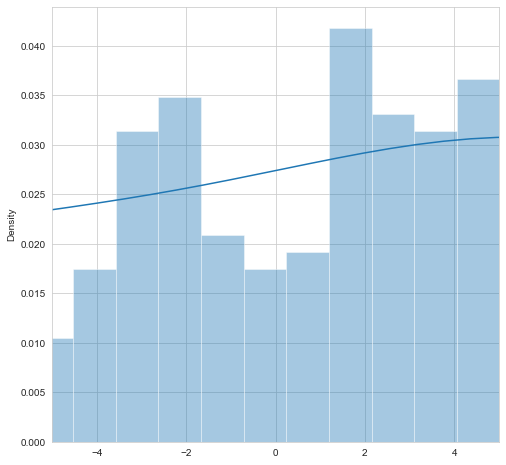

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-5,5])
sns.distplot(result.resid,bins=100);

We assume **normal distribution of error terms** in LR. 
The previous plot should look like a Gaussian distribution
in order to validate the assumption.

This is an indicator that LR may not perform the best.

We will also run a *QQ-plot* to validate our model.

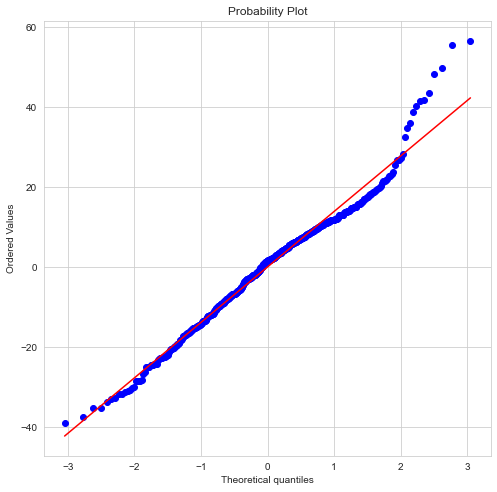

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
scipy.stats.probplot(result.resid, plot=plt);

The *QQ-plot* looks fine.

LinearRegression cannot be optimized since it has no hyperparameters.

In [33]:
alpha = [0.001,0.01,0.1,0.5,1,5,10,100]

param_grid={
    'alpha': alpha,
}

extra_scoring_cols = [
    'param_alpha',
]

ridge = Ridge(normalize=False, random_state=random_seed)
ridgeBest = hypertune(ridge, param_grid, extra_scoring_cols)
evaluate('Ridge(best)', ridgeBest)

0 minutes, 1 seconds
{
  "alpha": 5
}


,param_alpha,mean_test_mae,mean_test_mse,mean_test_r2
5,5,-10.893708,-198.720952,0.884009
6,10,-10.924205,-201.524596,0.882638
4,1,-10.939511,-197.780881,0.884331
3,0.5,-10.948774,-197.766853,0.884310
2,0.1,-10.956248,-197.774413,0.884282


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
RF(default),8.52765,109.374549,0.937331
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
SVR(default),11.970851,296.557886,0.830078
GP(default),13.635264,959.67947,0.450122
NN(default),18.961444,524.995914,0.699188
KRR(default),41.821578,2408.593873,-0.380077


In [34]:
penalty = ['l1', 'l2','elasticnet']
alpha = [0.01,0.1,0.5,1,5]
learning_rate=['constant', 'optimal', 'invscaling']

param_grid={
    'penalty': penalty,
    'alpha': alpha,
    'learning_rate': learning_rate,
}

extra_scoring_cols = [
    'param_penalty',
    'param_alpha',
    'param_learning_rate'
]

sgd = SGDRegressor(random_state=random_seed)
sgdBest = hypertune(sgd, param_grid, extra_scoring_cols)
evaluate('LR-SGD(best)', sgdBest)

0 minutes, 0 seconds
{
  "alpha": 1,
  "learning_rate": "invscaling",
  "penalty": "l1"
}


,param_penalty,param_alpha,param_learning_rate,mean_test_mae,mean_test_mse,mean_test_r2
33,l1,1,invscaling,-10.862998,-201.516480,0.882697
24,l1,0.5,invscaling,-10.871535,-198.720854,0.884034
27,l1,1,constant,-10.872044,-202.463368,0.882263
7,l2,0.01,invscaling,-10.895459,-199.008431,0.883862
8,elasticnet,0.01,invscaling,-10.897372,-198.678595,0.884012


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
RF(default),8.52765,109.374549,0.937331
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
LR-SGD(best),10.544425,191.665847,0.890179
SVR(default),11.970851,296.557886,0.830078
GP(default),13.635264,959.67947,0.450122
NN(default),18.961444,524.995914,0.699188


### k-Nearest Neighbors

In [35]:
n_neighbors = [2,5,10,20,30]
weights=['uniform','distance']
p=[1,2] # Minkowski distance

param_grid={
    'n_neighbors': n_neighbors,
    'weights': weights,
    'p': p,
}

extra_scoring_cols = [
    'param_n_neighbors',
    'param_weights',
    'param_p',
]

knn = KNeighborsRegressor()
knnBest = hypertune(knn, param_grid, extra_scoring_cols)
evaluate('KNN(best)', knnBest)

0 minutes, 0 seconds
{
  "n_neighbors": 10,
  "p": 1,
  "weights": "distance"
}


,param_n_neighbors,param_weights,param_p,mean_test_mae,mean_test_mse,mean_test_r2
9,10,distance,1,-7.562423,-112.180007,0.934702
7,5,distance,2,-7.574991,-110.245633,0.935669
5,5,distance,1,-7.594587,-114.940204,0.932936
11,10,distance,2,-7.676828,-112.466091,0.934478
4,5,uniform,1,-7.890667,-122.039867,0.928961


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
RF(default),8.52765,109.374549,0.937331
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
LR-SGD(best),10.544425,191.665847,0.890179
SVR(default),11.970851,296.557886,0.830078
GP(default),13.635264,959.67947,0.450122


### Random Forest

In [36]:
n_estimators = [50,100]
criterion = ['mse', 'mae']
max_depth = [100,None]
min_samples_split = [2,4]
min_samples_leaf = [2,4]
max_features = ['auto','sqrt','log2']

param_grid={
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf, 
    'max_features': max_features,
}

extra_scoring_cols = [
    'param_n_estimators', 
    'param_criterion',  
    'param_max_depth', 
    'param_min_samples_leaf', 
    'param_min_samples_split',
    'param_max_features',
]

rf = RandomForestRegressor(random_state=random_seed, n_jobs=-1)
rfBest = hypertune(rf, param_grid, extra_scoring_cols)
evaluate('RF(best)', rfBest)

0 minutes, 25 seconds
{
  "criterion": "mae",
  "max_depth": 100,
  "max_features": "auto",
  "min_samples_leaf": 2,
  "min_samples_split": 2,
  "n_estimators": 100
}


,param_n_estimators,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_test_mae,mean_test_mse,mean_test_r2
75,100,mae,None,2,4,auto,-6.857400,-100.174802,0.941083
73,100,mae,None,2,2,auto,-6.857400,-100.174802,0.941083
51,100,mae,100,2,4,auto,-6.857400,-100.174802,0.941083
49,100,mae,100,2,2,auto,-6.857400,-100.174802,0.941083
3,100,mse,100,2,4,auto,-6.908476,-99.988074,0.940672


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
LR-SGD(best),10.544425,191.665847,0.890179
SVR(default),11.970851,296.557886,0.830078


### Kernel Regression

In [37]:
alpha = [0.01,0.1,0.5,1,5]
kernel = ['linear','polynomial','rbf','sigmoid']

param_grid={
    'alpha': alpha,
    'kernel': kernel
}

extra_scoring_cols = [
    'param_alpha', 
    'param_kernel'
]

krr = KernelRidge()
krrBest = hypertune(krr, param_grid, extra_scoring_cols)
evaluate('KRR(best)', krrBest)

0 minutes, 2 seconds
{
  "alpha": 0.01,
  "kernel": "rbf"
}


,param_alpha,param_kernel,mean_test_mae,mean_test_mse,mean_test_r2
2,0.01,rbf,-7.005836,-87.454813,0.948050
5,0.1,polynomial,-7.438992,-95.000640,0.943891
6,0.1,rbf,-7.440935,-97.390404,0.942531
1,0.01,polynomial,-7.456117,-94.254199,0.944220
9,0.5,polynomial,-7.593609,-99.522502,0.941415


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
KRR(best),7.46016,85.754101,0.950865
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
LR-SGD(best),10.544425,191.665847,0.890179


### Gaussian Process

In [38]:
from sklearn.gaussian_process.kernels import DotProduct, RBF

kernel = [DotProduct(), RBF()]
param_grid={
    'kernel': kernel,
}

extra_scoring_cols = [
    'param_kernel', 
]

gp = GaussianProcessRegressor(random_state=random_seed)
gpBest = hypertune(gp, param_grid, extra_scoring_cols, print_scores=False)
evaluate('GP(best)', gpBest)

0 minutes, 7 seconds


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
KRR(best),7.46016,85.754101,0.950865
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
GP(best),10.43422,185.597957,0.893656


### SVR

In [39]:
kernel = ['linear', 'poly', 'sigmoid']
degree = [2,3,5,7]
gamma = ['scale', 'auto']
C = [0.00001,0.0001,0.001,0.01,0.1,0.5,1,5,10,100]

param_grid={
    'kernel':kernel,
    'degree': degree,
    'gamma': gamma,
    'C': C,
}

extra_scoring_cols = [
    'param_kernel',
    'param_C',
    'param_degree',
    'param_gamma',
]

svr = SVR()
svrBest = hypertune(svr, param_grid, extra_scoring_cols)
evaluate('SVR(best)', svrBest)

0 minutes, 11 seconds
{
  "C": 100,
  "degree": 2,
  "gamma": "scale",
  "kernel": "linear"
}


,param_kernel,param_C,param_degree,param_gamma,mean_test_mae,mean_test_mse,mean_test_r2
228,linear,100,5,scale,-10.81326,-202.103244,0.882025
237,linear,100,7,auto,-10.81326,-202.103244,0.882025
234,linear,100,7,scale,-10.81326,-202.103244,0.882025
231,linear,100,5,auto,-10.81326,-202.103244,0.882025
216,linear,100,2,scale,-10.81326,-202.103244,0.882025


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
KRR(best),7.46016,85.754101,0.950865
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655
GP(best),10.43422,185.597957,0.893656


### Neural Networks

In [40]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]
alpha = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]

param_grid={
    'hidden_layer_sizes':sizes,
    'alpha':alpha
}

extra_scoring_cols = [
    'param_hidden_layer_sizes', 
    'param_alpha',
]

nn = MLPRegressor(
    solver='lbfgs', 
    activation='relu',
    random_state=random_seed,
    max_iter=500
)
nnBest = hypertune(nn, param_grid, extra_scoring_cols)
evaluate('NN(best)', nnBest)

0 minutes, 14 seconds
{
  "alpha": 0.5,
  "hidden_layer_sizes": [
    8,
    8
  ]
}


,param_hidden_layer_sizes,param_alpha,mean_test_mae,mean_test_mse,mean_test_r2
67,"[8, 8]",0.5,-6.860518,-90.489265,0.945974
83,"[8, 8, 8]",1,-6.955412,-94.008709,0.944113
79,"[8, 8]",1,-6.957666,-91.174958,0.946236
55,"[8, 8]",0.1,-6.978636,-92.133714,0.945140
59,"[8, 8, 8]",0.1,-6.984554,-91.354434,0.945837


,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
KRR(best),7.46016,85.754101,0.950865
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
NN(best),9.339569,128.819351,0.926189
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655


## Model Evaluation & Results

In [41]:
plot_results()

,MAE,MSE,$R^2$
KNN(default),7.076,87.3216,0.949966
KNN(best),7.163383,88.82087,0.949107
KRR(best),7.46016,85.754101,0.950865
RF(default),8.52765,109.374549,0.937331
RF(best),8.604475,112.214441,0.935703
NN(best),9.339569,128.819351,0.926189
Ridge(best),10.365239,186.353718,0.893223
Ridge(default),10.418818,185.598983,0.893655
LR-SGD(default),10.429354,186.005398,0.893423
LR(default),10.434174,185.599129,0.893655


In [42]:
bestModel = knnBest.best_estimator_

In [43]:
y_pred = bestModel.predict(X_test)
mae, mse, r2 = compute_metrics(y_test, y_pred)
print('MAE: {:.2f}'.format(mae))
print('MSE: {:.2f}'.format(mse))
print('R^2: {:.2f}'.format(r2))

MAE: 11.60
MSE: 230.16
R^2: 0.86


The mean absolute value error is $11.6$ which shows that our model is not accurate, but it can still make good predictions.

The mean square error is $230.2$ which shows that we have outliers.

The $R^2$ score is $0.86$ which shows that our model fit the data well.

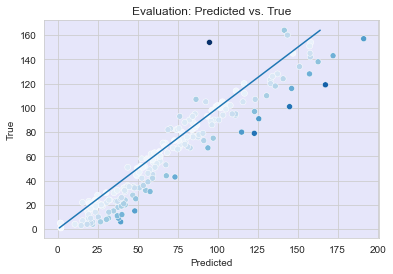

In [44]:
hue = np.abs(y_pred - y_test)

fig, ax = plt.subplots()
_ = sns.scatterplot(x=y_pred, y=y_test, 
                hue=hue, legend=False, 
                palette=colormap, ax=ax)
_ = sns.lineplot(x=[y_test.min(), y_test.max()], 
             y=[y_test.min(), y_test.max()], 
             ax = ax)
_ = ax.set_xlabel('Predicted')
_ = ax.set_ylabel('True')
ax.set_facecolor('lavender')
_ = plt.title('Evaluation: Predicted vs. True',fontsize=12, y=1.0)